In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pip install pymorphy2

     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 7.1MB 6.4MB/s 


In [0]:
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import collections
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Activation, Dropout
from keras.layers.embeddings import Embedding
import gensim.downloader
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn
import pymorphy2

# DataSet
 
Загрузка словаря RuSentilex в формате .csv
*   https://www.labinform.ru/pub/rusentilex/index.htm



In [0]:
df = pd.read_csv('drive/My Drive/coursework/rusentilex.csv')

In [6]:
df.head(3)

,term,tone
0,остепеняться,positive
1,трудолюбивый,positive
2,беспалевный,positive


In [7]:
len(df)

10668

Всего в словаре 10668 слов.

In [0]:
# получение id тональности
def get_ids(all_tones):
    result = []

    for tone in all_tones:
        result.append(all_tones.unique().tolist().index(tone))

    return result

In [0]:
labels = get_ids(df['tone'])
total_words = df['term']
# перемешиваем
total_words, labels = sklearn.utils.shuffle(total_words, labels)

In [0]:
# получаем список для корректной работы с моделью
sentences = [[word] for word in total_words]

In [0]:
counter = collections.Counter()

In [0]:
#считаем максимальную длину предложений (в словаре могут быть словосочетания), а также частоту всех слов, считанных из файла
maxlen = 0
for words in sentences:
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1

In [19]:
vocab_sz = len(counter) + 1 
print('Размер словаря: ' + str(vocab_sz))

Размер словаря: 10669


Задаем необходимые константные значения и загружаем русскоязычную модель Word2Vec

In [0]:
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
EPOCH_SIZE = 15
BATCH_SIZE = 164

In [0]:
word2vec_model = gensim.downloader.load("word2vec-ruscorpora-300")

# Работа с Keras

In [0]:
#создаём матрицу размером размерность словаря*размерность вектора слова
embedding_weights = np.zeros((len(counter) + 1, EMBEDDING_DIM))
index = 0
#сортируем слова по частоте встречаемости
sorted_counter = counter.most_common()
#для каждого слова из нашего словаря задаём вектор из word2vec_model в матрицу
for word in sorted_counter:
    try:
      embedding_weights[index, :] = word2vec_model[word[0]] 
      index+=1     
    #если нет слова в словаре word2vec_model
    except KeyError:
      index+=1
      pass

Собираем модель для обучения:
1 слой модели – русскоязычный word2vec

In [0]:
model = Sequential()
model.add(Embedding(len(counter) + 1, EMBEDDING_DIM, input_length=maxlen, weights=[embedding_weights],
                    trainable=True))
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [198]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 1, 300)            3200700   
_________________________________________________________________
gru_11 (GRU)                 (None, 32)                31968     
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 99        
Total params: 3,232,767
Trainable params: 3,232,767
Non-trainable params: 0
_________________________________________________________________


# Train Model

Обучение модели

In [0]:
# Создание единого словаря (слово -> число) для преобразования на основе списка текстов sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [0]:
#заменяем слова каждого предложения на числа
X = tokenizer.texts_to_sequences(sentences)
#уравниваем все предложения до размера maxlen
X = pad_sequences(X, maxlen = maxlen)

In [0]:
y = to_categorical(labels)

In [244]:
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCH_SIZE, 
                    callbacks=[ModelCheckpoint('drive/My Drive/coursework/model.h5', save_best_only=True)],
                    validation_split=VALIDATION_SPLIT, verbose=2)

Train on 8534 samples, validate on 2134 samples
Epoch 1/15
 - 0s - loss: 1.2547e-05 - acc: 1.0000 - val_loss: 0.2933 - val_acc: 0.8791
Epoch 2/15
 - 0s - loss: 1.2243e-05 - acc: 1.0000 - val_loss: 0.2933 - val_acc: 0.8791
Epoch 3/15
 - 0s - loss: 1.1904e-05 - acc: 1.0000 - val_loss: 0.2933 - val_acc: 0.8791
Epoch 4/15
 - 0s - loss: 1.1477e-05 - acc: 1.0000 - val_loss: 0.2933 - val_acc: 0.8791
Epoch 5/15
 - 0s - loss: 1.1166e-05 - acc: 1.0000 - val_loss: 0.2933 - val_acc: 0.8791
Epoch 6/15
 - 0s - loss: 1.0781e-05 - acc: 1.0000 - val_loss: 0.2933 - val_acc: 0.8791
Epoch 7/15
 - 0s - loss: 1.0540e-05 - acc: 1.0000 - val_loss: 0.2933 - val_acc: 0.8791
Epoch 8/15
 - 0s - loss: 1.0107e-05 - acc: 1.0000 - val_loss: 0.2933 - val_acc: 0.8791
Epoch 9/15
 - 0s - loss: 9.9055e-06 - acc: 1.0000 - val_loss: 0.2933 - val_acc: 0.8791
Epoch 10/15
 - 0s - loss: 9.5076e-06 - acc: 1.0000 - val_loss: 0.2933 - val_acc: 0.8791
Epoch 11/15
 - 0s - loss: 9.3000e-06 - acc: 1.0000 - val_loss: 0.2933 - val_acc: 

Модель обучилась с точностью ~88%

Построение графика потерь:

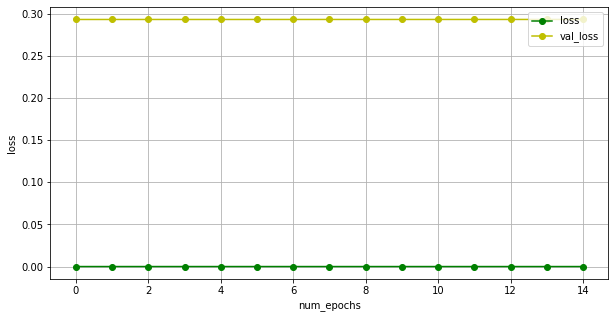

In [312]:
x = range(EPOCH_SIZE)
plt.figure(figsize = (10, 5))
plt.grid(True)
plt.plot(x, history.history['loss'], 'go-', label = 'loss')
plt.plot(x, history.history['val_loss'], 'yo-', label = 'val_loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(loc = 'upper right')

# Test Model

Проверка работоспособности на небольших данных

In [0]:
# метод для преобразования из id тональности в его словесное значение (0 -> positive)
def from_tone(prediction, tones):
  answers = []

  for i in range(prediction.shape[0]):
    answers.append(tones[prediction[i]])

  return answers

In [0]:
test_samples = ['ненужный', 'отвратительный', 'прикольный', 'милый', 'нежный']

In [314]:
test_samples = [[test] for test in test_samples]
test_samples

[['ненужный'], ['отвратительный'], ['прикольный'], ['милый'], ['нежный']]

In [0]:
test_samples_tokens = tokenizer.texts_to_sequences(test_samples)

In [0]:
test_samples_pad = pad_sequences(test_samples_tokens, maxlen=maxlen)

In [0]:
predict = model.predict_classes(x=test_samples_pad)

In [318]:
answers = from_tone(predict, df['tone'].unique().tolist()) 
answers

['negative', 'negative', 'positive', 'positive', 'positive']

# Классификация неразмеченного словаря, полученного из отзывов

In [0]:
import json

In [0]:
# загружаем неразмеченный словарь из json файла
with open('drive/My Drive/coursework/unallocated_dictionary.json', 'r', encoding='utf-8') as f:
    js = json.load(f)

In [248]:
js[:5]

[['телефон_NOUN', 13004],
 ['очень_ADVB', 7831],
 ['экран_NOUN', 6981],
 ['хороший_ADJF', 5305],
 ['камера_NOUN', 5178]]

In [0]:
unallocated_words = [[word[0][:-5]] for word in js]

In [281]:
unallocated_words[:6]

[['телефон'], ['очень'], ['экран'], ['хороший'], ['камера'], ['весь']]

In [0]:
unallocated_words_tokens = tokenizer.texts_to_sequences(unallocated_words)

In [0]:
unallocated_words__pad = pad_sequences(unallocated_words_tokens, maxlen=maxlen)

In [0]:
predict = model.predict_classes(x=unallocated_words__pad)

In [0]:
answers = from_tone(predict, df['tone'].unique().tolist())

In [0]:
keys = [word[0] for word in js]

In [0]:
dictionary = dict(zip(keys, answers))

In [0]:
import itertools

In [327]:
dict(itertools.islice(dictionary.items(), 6))

{'весь_ADJF': 'negative',
 'камера_NOUN': 'negative',
 'очень_ADVB': 'negative',
 'телефон_NOUN': 'negative',
 'хороший_ADJF': 'positive',
 'экран_NOUN': 'negative'}

In [0]:
# сохраняем размеченный словарь в json файл
with open('drive/My Drive/coursework/tagged_dictionary.json', 'w', encoding='utf-8') as f:
    json.dump(dictionary, f, ensure_ascii=False, indent=4)

In [0]:
# так же сохраняем словарь в csv файл
import csv
from itertools import zip_longest
d = [keys, answers]
export_data = zip_longest(*d, fillvalue = '')
with open('drive/My Drive/coursework/tagged_dictionary.csv', 'w', encoding='utf-8', newline='') as f:
      wr = csv.writer(f)
      wr.writerow(("term", "tone"))
      wr.writerows(export_data)
f.close()

In [0]:
tagged_dictionary = pd.read_csv('drive/My Drive/coursework/tagged_dictionary.csv')

In [331]:
tagged_dictionary[:15]

,term,tone
0,телефон_NOUN,negative
1,очень_ADVB,negative
2,экран_NOUN,negative
3,хороший_ADJF,positive
4,камера_NOUN,negative
5,весь_ADJF,negative
6,работать_INFN,negative
7,день_NOUN,negative
8,батарея_NOUN,negative
9,приложение_NOUN,negative
